In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
import tensorflow_io as tfio

from IPython import display
from IPython.display import Audio



In [3]:
DATASET_PATH = '/kaggle/input/mini-speech2/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)

In [4]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=128,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
#print("label names:", label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.


In [5]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [6]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

**Convert waveforms to spectrograms**

In [7]:
def get_spectrogram(waveform):
    # Convert the waveform to a spectrogram via a STFT. SFTF -> returning a 2D tensor that you can run standard convolutions on.
    #spectrogram = tf.signal.stft(
    #    waveform, frame_length=255, frame_step=128) # 124, 129
    spectrogram = tfio.audio.spectrogram(waveform, nfft=512, window=512, stride=130)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    
    return spectrogram

In [8]:
for example_audio, example_labels in train_ds.take(1):  
    break

for i in range(3):
    label = label_names[example_labels[i]]
    waveform = example_audio[i]
    spectrogram = get_spectrogram(waveform)
    
    #print(waveform)
    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=16000))

Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 257, 1)
Audio playback


Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 257, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 257, 1)
Audio playback


**Mel-Spectogram**

In [9]:
def timeMasking(audio):
    time_mask = tfio.audio.time_mask(audio, param=8)
    return time_mask

In [10]:
def specAugment(audio):
    freq_mask = tfio.audio.freq_mask(audio, param=8)
    return freq_mask

In [11]:
def create_mel_specto(audio):
        
    spectrogram = tfio.audio.spectrogram(audio, nfft=512, window=300, stride=130)
    #spectrogram = tfio.audio.spectrogram(audio, nfft=512, window=512, stride=130)
    
    # Convert to mel-spectrogram
    mel_spectrogram = tfio.audio.melscale(
        spectrogram, rate=32000, mels=128, fmin=0, fmax=14000) 
    # spectrogram, rate=16000, mels=129, fmin=0, fmax=7000) 

    # Convert to db scale mel-spectrogram
    dbscale_mel_spectrogram = tfio.audio.dbscale(
        mel_spectrogram, top_db=85)
    
    dbscale_mel_spectrogram = tf.abs(dbscale_mel_spectrogram) # * -1 wenn zahl < 0
    
    dbscale_mel_spectrogram = dbscale_mel_spectrogram[..., tf.newaxis]
    return dbscale_mel_spectrogram # Output -> ( stride , mels, tf.newaxis )

In [12]:
spectrogram = get_spectrogram(example_audio[5])
print(example_audio[1].shape)
print(spectrogram.shape)
compair = create_mel_specto(example_audio[5])
print(compair.shape)

(16000,)
(124, 257, 1)
(124, 128, 1)


**Display Spectogram**

In [13]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
        
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

In [15]:
def make_spec_ds(ds):
    return ds.map(
        map_func=lambda audio,label: (get_spectrogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE)

In [16]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
    break

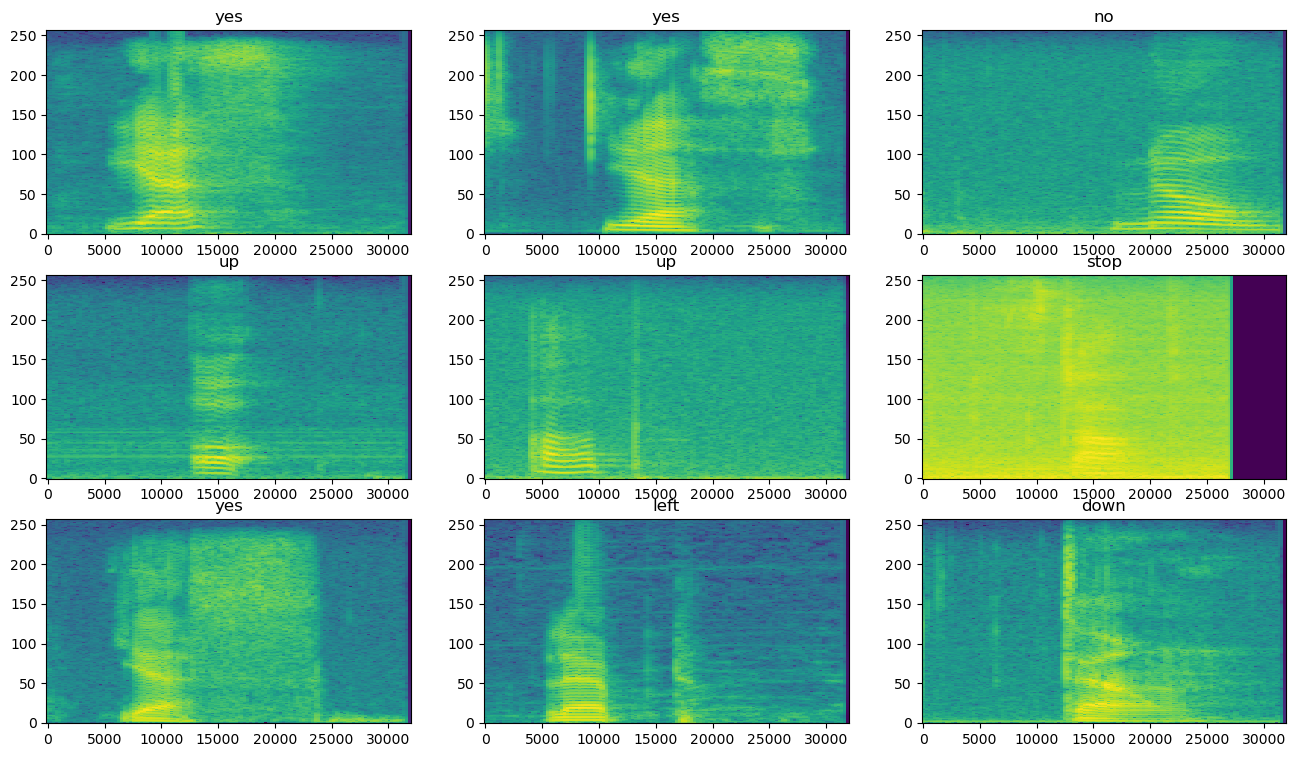

In [17]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i], ax)
    ax.set_title(label_names[example_spect_labels[i]])

plt.show()

**Build and Train**

In [18]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [19]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
     layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 257, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

In [21]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [22]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)
tf.keras.models.save_model(model,'teLiteMod.h5')

Epoch 1/10
50/50 [==============================] - 17s 320ms/step - loss: 1.8505 - accuracy: 0.3322 - val_loss: 1.6102 - val_accuracy: 0.4974
Epoch 2/10
50/50 [==============================] - 13s 261ms/step - loss: 1.4457 - accuracy: 0.4917 - val_loss: 1.2764 - val_accuracy: 0.5911
Epoch 3/10
50/50 [==============================] - 13s 270ms/step - loss: 1.1700 - accuracy: 0.5836 - val_loss: 1.0473 - val_accuracy: 0.6589
Epoch 4/10
50/50 [==============================] - 13s 260ms/step - loss: 0.9855 - accuracy: 0.6527 - val_loss: 0.9386 - val_accuracy: 0.6849
Epoch 5/10
50/50 [==============================] - 13s 265ms/step - loss: 0.8449 - accuracy: 0.6989 - val_loss: 0.8688 - val_accuracy: 0.7214
Epoch 6/10
50/50 [==============================] - 13s 259ms/step - loss: 0.7498 - accuracy: 0.7367 - val_loss: 0.7740 - val_accuracy: 0.7448
Epoch 7/10
50/50 [==============================] - 13s 264ms/step - loss: 0.6685 - accuracy: 0.7655 - val_loss: 0.7392 - val_accuracy: 0.7526

In [26]:
tf.keras.models.save_model(model,'teLiteMod.h5')

In [69]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_mod = converter.convert()
open("/kaggle/working/teLiteMod_optim.tflite", "wb").write(tflite_mod) # min. 20

1631704

Text(0, 0.5, 'Accuracy [%]')

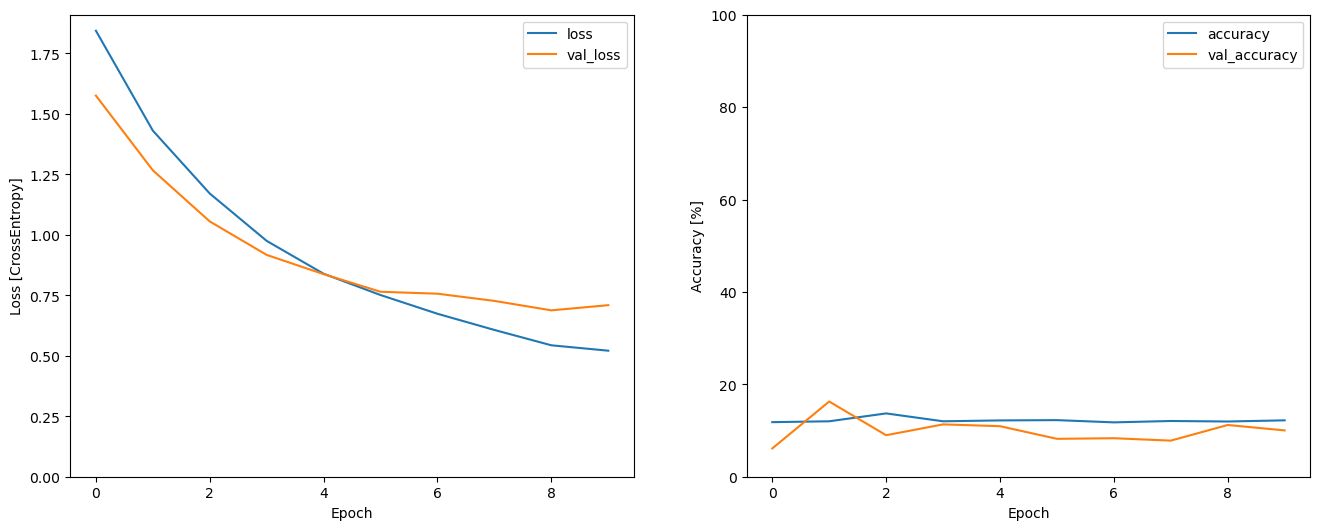

In [45]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

**Evaluate Model**

In [46]:
model.evaluate(test_spectrogram_ds, return_dict=True)

7/7 [==============================] - 2s 200ms/step - loss: 0.6192 - accuracy: 0.1575


{'loss': 0.6191960573196411, 'accuracy': 0.15745192766189575}

7/7 [==============================] - 0s 54ms/step


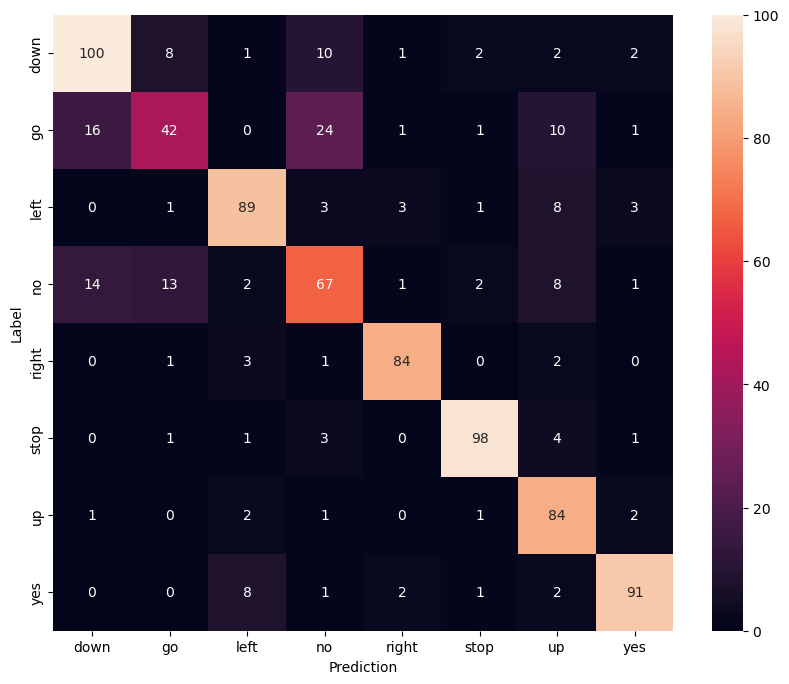

In [49]:
y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [48]:
x = data_dir/'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = create_mel_specto(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['no', 'yes', 'down', 'go', 'left', 'up', 'right', 'stop']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

ValueError: Input 0 of layer "sequential_7" is incompatible with the layer: expected shape=(None, 124, 257, 1), found shape=(1, 124, 128, 1)